# Machine Learning Algorithms from Scratch

## Contents

1. K-means
2. Gradient Descent
3. Linear Regression
4. Logistic Regression (Binary Classification, <span style="color:red">Multiclass Classification</span>)
5. Principal Components Analysis
6. K Nearest Neighbours
7. Decision Trees (Optimise over features <span style="color:red">and threshholds</span>)
8. <span style="color:red">Support Vector Machine</span>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline

from IPython.display import display

print (sys.version)

Populating the interactive namespace from numpy and matplotlib
3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


## 1. K-means

We have a set of unlabelled data. We want to find clusters in the data. In particular we want to finud the cluster centres and assign every data point to a cluster.

### Algorithm:

- Randomly define k cluster centres (must choose k).
- Assign each data point to the nearest cluster centre.
- Iteratively:
  1. Re-calculate the cluster centres as the Euclidean mean of the members of each cluster.
  2. Assign each data point to the nearest cluster centre.
  3. Calculate the number of labels that changed.
  4. When the labels stop changing we are done.

In [2]:
class Kmeans:
    def __init__(self, data, k = 2):
        self.data = data
        self.n_data, self.n_features = data.shape
        self.tol = 0.01

    def get_initial_centres(self, k, debug = True, seed = -1):
        if debug:
            return data[:k,:]
        if seed > 0:
            np.random.seed(seed)
        c_idx = np.random.choice(self.n_data, k, replace=False)
        return data[c_idx,:]
    
    def distances_from_centres(self, centres, p):
        return np.sqrt(np.sum((p-centres)*(p-centres), axis=1))

    def nearest_cluster(self, centres):
        cluster_labels = np.zeros((self.n_data,1))
        for di in range(self.n_data):
            cluster_labels[di,0] = np.argmin(self.distances_from_centres(centres, self.data[di,:]))
        return cluster_labels

    def calculate_cluster_centres(self, k, cluster_labels):
        centres = np.zeros((k, self.n_features))
        for c in range(k):
            n_pts = np.sum(cluster_labels == c)
            # Don't move the point if no data points are assigned to the cluster (prevents division by zero)
            if n_pts > 1:
                centres[c,:] = np.sum((cluster_labels == c)*self.data, axis=0) / n_pts
        return centres
    
    def find_cluster_centres(self, initial_centres, max_iterations = 20):
        
        centres = np.copy(initial_centres)
        k = centres.shape[0]
        labels = np.zeros((self.n_data,1))
        
        for i in range(max_iterations):
            
            # Assign each data point to the closest cluster centre
            new_labels = self.nearest_cluster(centres)

            # Calculate the new cluster centres (mean of all points in each cluster)
            new_centres = self.calculate_cluster_centres(k, new_labels)

            # Calculate the number of labels that changed
            n_labels_changed = self.n_data - np.sum(new_labels==labels)

            # Calculate the max change in the distance between cluster centres
            #max_centre_change = np.max(self.distances_from_centres(centres, new_centres))
            #print("label:", n_label_changed, "centre: ", max_centre_change)
            
            if n_labels_changed == 0:
                print("converged in {} iterations".format(i))
                break
            
            centres = np.copy(new_centres)
            labels = np.copy(new_labels)
            
        return centres, new_labels

Intial centres
[[-3.63744959  1.9586027 ]
 [-1.31599867 -2.35340998]
 [-0.95991085 -2.91844004]
 [-3.89526695  2.08972912]]
converged in 6 iterations
Final centres
[[ 2.1858432   2.03485541]
 [-1.89125317 -1.80856091]
 [ 2.05373119 -1.88840285]
 [-2.13477223  2.02228883]]


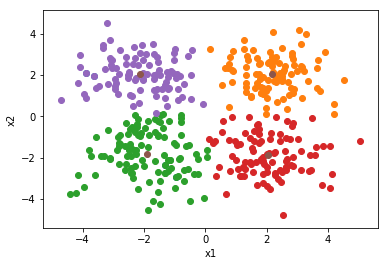

In [3]:
"""Set-up some data"""
np.random.seed(1)
x = 2
data1 = np.random.normal(size=(100, 2)) + [ x, x]
data2 = np.random.normal(size=(100, 2)) + [ x,-x]
data3 = np.random.normal(size=(100, 2)) + [-x,-x]
data4 = np.random.normal(size=(100, 2)) + [-x, x]
data  = np.concatenate((data1, data2, data3, data4))
np.random.shuffle(data)

"""Set-up our Kmeans object"""
my_kmeans = Kmeans(data)
initial_centres = my_kmeans.get_initial_centres(4)

print('Intial centres')
print(initial_centres)

"""Plot the initial centres"""
plt.xlabel('x1')
plt.ylabel('x2')
ax = plt.scatter(initial_centres[:,0], initial_centres[:,1])

"""Find the cluster centres using Kmeans"""
centres, labels = my_kmeans.find_cluster_centres(initial_centres)
print("Final centres")
print(centres)

"""Plot the data clusters given by Kmeans"""
dataa = data[np.where(labels[:,0] == 0)]
datab = data[np.where(labels[:,0] == 1)]
datac = data[np.where(labels[:,0] == 2)]
datad = data[np.where(labels[:,0] == 3)]

ax = plt.scatter(dataa[:,0], dataa[:,1])
ax = plt.scatter(datab[:,0], datab[:,1])
ax = plt.scatter(datac[:,0], datac[:,1])
ax = plt.scatter(datad[:,0], datad[:,1])
ax = plt.scatter(centres[:,0], centres[:,1])

## 2. Gradient Descent

We have a function ```f(x)``` we are trying to find the minima of. We know the gradient of ```f(x)``` i.e. ```f'(x)```. We use the gradient to interatively take steps size a downhill.

- Start with an initial guess ```x = x0```.
- Our new guess is ```x1 = x0 - a * f'(x0)``` where a is the learning rate.
- We stop when the changes in f(x) from one x to the next become small.

In [4]:
class GradientDescent:
    def __init__(self, cost_function, learning_rate = 0.1, tol = 0.01, max_iter = 10):
        # cost_function should have the methods value and delta
        self.cost = cost_function
        self.alpha = learning_rate
        self.tol = tol
        self.max_iter = max_iter
        
    def find_minima(self, initial_params):
        params = np.copy(initial_params)
        val = self.cost.value(params)
        cost = [val]
        for i in range(self.max_iter):
            new_params = params - self.alpha * self.cost.delta(params)
            new_val = self.cost.value(new_params)
            cost.append(new_val)
            if np.abs(new_val - val) < self.tol:
                print('converged in {} iterations'.format(i))
                break
            params = np.copy(new_params)
            val = np.copy(new_val)
        return new_params, cost

## 3. Linear Regression

We have some data ```{x, y}```. We want to find a line of best fit ```y_hat = Ax```. To do this we minimise the sum of sq diffs between ```y``` and ```y_hat```.

- Start with a guess for A (A0).
- Calculate ```y_hat = A0 x```.
- Cost function is mean sq differences: ```mean[(y-y_hat)*(y-y_hat)]```.
- Gradient of the cost function is: ```2*mean[(y-y_hat)*x, axis=1].T```.
- Minimise the cost using gradient descent to find the A that gives the best fit.

In [5]:
class LinearFunction:
    """Form: y = Ax"""
    def __init__(self, x, y):
        self.n_feat, self.n_data = x.shape
        self.x = np.concatenate((np.ones((1, self.n_data)), x), axis=0)
        #params will be an n_feat + 1 dimensional vector
        self.y = y
    
    def value(self, params):
        return params.dot(self.x)

    def deriv(self, params):
        return self.x


class MeanSumSqDiffs:
    def __init__(self, y, func):
        self.y = y
        self.func = func
        self.yhat = np.zeros_like(y)
    
    def value(self, params):
        self.y_hat = self.func.value(params)
        return np.mean((self.y - self.y_hat)*(self.y - self.y_hat))
    
    def delta(self, params):
        dy_hat = self.func.deriv(params)
        return 2 * np.transpose(np.mean((self.y_hat - self.y) * dy_hat, axis=1, keepdims=True))

converged in 65 iterations


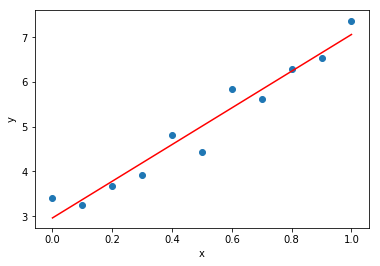

In [6]:
"""Set-up some data"""
m = 11
step = 1.0 / (m - 1)
x = np.reshape(np.arange(0, 1 + step, step), (1, m))
np.random.seed(1)
noise = 0.25 * np.random.randn(1, m)
params = np.reshape(np.array([3, 4]), (1, 2))
y = np.reshape(params[0][0] + params[0][1] * x + noise, (1, m))

"""Plot the data"""
ax = plt.scatter(x, y)

"""Set-up classes and find the best params using GradientDescent"""
linear_func = LinearFunction(x, y)
cost_func = MeanSumSqDiffs(y, linear_func)
grad_desc = GradientDescent(cost_func, learning_rate = 0.5, tol = 0.000001, max_iter = 100)
params, cost = grad_desc.find_minima(np.reshape(np.array([1, 1]), (1, 2)))

"""Plot our line of best fit"""
yhat = linear_func.value(params)
plt.xlabel('x')
plt.ylabel('y')
ax = plt.plot(np.transpose(x), np.transpose(yhat), 'red')

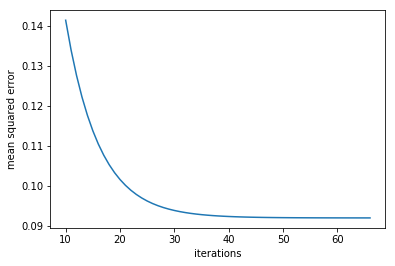

In [7]:
"""Plot the cost"""
start_index = 10
plt.gcf().clear()
plt.close()
plt.xlabel('iterations')
plt.ylabel('mean squared error')
ax = plt.plot(list(range(start_index, len(cost), 1)), cost[start_index:])

## 4. Logistic Regression

### 4.1 Binary Classification

- We want to find a decision boundary of the from ```Ax = 0``` where ```x = (1, xo, x1,..., xm)```.
- The probability of a data point x having a positive label in our model is given by ```y_hat = sigmoid(Ax)```.
- We find the ```A``` which best fits the data by maximising the liklihood of the data given the model which is equivalent to minimising the cross entropy.
- We use gradient decent.
- Cost function: ```mean[ -y*ln(y_hat) - (1-y)*ln(1-y_hat)]```.
- Gradient of the cost function: ```(y_hat-y).dot(x.T) / n_data```.

In [8]:
class LogisticRegression:
    def __init__(self, x, y):
        self.n_feat, self.n_data = x.shape
        self.x = np.concatenate((np.ones((1, self.n_data)), x), axis=0)
        #params will be an n_feat + 1 dimensional vector
        self.y = np.reshape(y, (1, self.n_data))
        self.prob = np.zeros_like(y)
    
    def z(self, params):
        """Linear Function of Form: z = Ax"""
        return params.dot(self.x)
    
    def value(self, params):
        """sigmoid(z), z = Ax"""
        self.prob = 1.0 / (1.0 + np.exp(-self.z(params)))
        return self.prob


class CrossEntropy:
    def __init__(self, y, func):
        self.n_data = y.shape[0]
        self.y = np.reshape(y, (1, self.n_data))
        self.y_hat = np.zeros_like(y)
        self.func = func
    
    def value(self, params):
        self.y_hat = self.func.value(params)
        return - np.mean( y*np.log(self.y_hat) + (1.0 - y)*np.log(1.0 - self.y_hat) )
    
    def delta(self, params):
        return (self.y_hat - self.y).dot(np.transpose(self.func.x))/self.n_data

converged in 78 iterations
[[-0.73458739  3.04377256  2.72099494]]


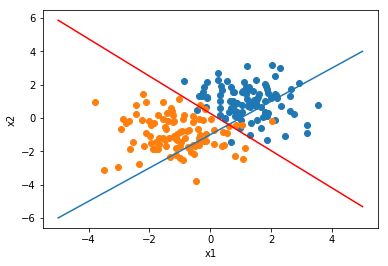

In [9]:
"""Set-up some data"""

np.random.seed(1)
x = 1
m = 200
data1 = np.concatenate((np.random.normal(size=(int(m/2), 2)) + [ x, x], np.ones((int(m/2), 1))), axis=1)
data2 = np.concatenate((np.random.normal(size=(int(m/2), 2)) + [-x, -x], np.zeros((int(m/2), 1))), axis=1)
data  = np.concatenate((data1, data2))
np.random.shuffle(data)
#data_df = pd.DataFrame(data=data, columns=['x1', 'x2', 'y'])
#display(data_df)
y = data[:,2]
#print(data[:,:2].shape)

"""Plot the different classes"""
plt.xlabel('x1')
plt.ylabel('x2')
ax = plt.scatter(data1[:,0], data1[:,1])
ax = plt.scatter(data2[:,0], data2[:,1])

"""Set-up our objects"""
model_prob = LogisticRegression(np.transpose(data[:,:2]), y)
cost_func = CrossEntropy(y, model_prob)
grad_desc = GradientDescent(cost_func, learning_rate = 3, tol = 0.00001, max_iter = 10000)

"""Pick an initial guess for a decision boundary and plot it"""
params = [1.0, -1.0, 1.0]
dbx = np.arange(-5, 6, 1)
dby = -(params[0] + params[1]*dbx)/params[2]
ax = plt.plot(dbx, dby)

"""Find the best params using GradienDescent and plot the new decision boundary"""
params, cost = grad_desc.find_minima(np.reshape(np.array(params), (1, 3)))
print(params)
dby = -(params[0][0] + params[0][1]*dbx)/params[0][2]
ax = plt.plot(dbx, dby, 'red')

"""Print the final params"""
y_hat = model_prob.value

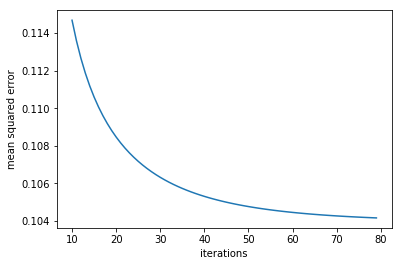

In [10]:
"""Plot the cost"""
start_index = 10
plt.gcf().clear()
plt.close()
plt.xlabel('iterations')
plt.ylabel('mean squared error')
ax = plt.plot(list(range(start_index, len(cost), 1)), cost[start_index:])

### 4.2 Multiclass Classification

In [11]:
"""
class LogisticRegression:
    def __init__(self, x, y, n_clases):
        self.n_feat, self.n_data = x.shape
        self.n_classes = n_clases
        self.x = np.concatenate((np.ones((self.n_data, 1)), x), axis=1)
        #params will be an n_feat + 1 dimensional vector
        self.y = y
            
    
    def z(self, params):
        #Linear Function of Form: z = Ax
        return params.dot(self.x)
    
    def value(self, params):
        #softmax(z), z = Ax
        ez = np.exp(self.z(params))
        ez_sum = np.sum(ez, axis=1)
        return ez / ez_sum

    def deriv(self, params):
        return pass


class CrossEntropy:
    def __init__(self, y, n_classes, func):
        self.n_data = y.shape[1]
        self.n_classes = n_classes
        self.y = y
        self.y_hat = np.zeros_like(y)
        self.func = func
    
    def value(self, params):
        y_hat = self.func.value(params)
        # yhat is an n_classes X n_data
        for i in range(self.n_data):
            self.y_hat[i] = y_hat[self.y[i], i]
        return -np.sum( np.log(self.yhat) )
    
    def delta(self, params):
        dy_hat = self.func.deriv(params)
        #print('testing', np.mean((self.y_hat - self.y) * dy_hat, axis=0, keepdims=True).shape)
        return pass
"""
print('To be continued...')

To be continued...


## 5. Principal Components Analysis

- We have unlabelled data.
- We want to find a new co-ordinate system, such that our basis vectors (though still orthogonal) are directed in descending order of variance on our data, i.e. the first co-ordinate is in the direction of maximal variance, the second co-ordinate is in the direction of maximal variance (orthogonal to the first) and so on.

### Algorithm

1. Calculate the (n_feat x n_feat) covariance matrix for the data.
2. Calculate the eigenvectors and eigenvalues of the covariance matrix - these are the basis vectors and corresponding variance in those directions.
3. Sort the eigenvectors and eigenvalues in descending order of the size of the eigenvalues.

Notes:

- The ith eigenvalue tells how much variance there is in the direction of the ith eigenvector.
- To transform data points from the original co-ordinate to the new we simply apply the transformation using the matrix of eigenvectors.

In [12]:
class PCA:
    def __init__(self, X):
        self.n_data, self.n_feat = X.shape
        self.X = np.transpose(X)
        self.mu = np.mean(self.X, axis=1, keepdims=1)
        self.var = np.var(self.X, axis=1, keepdims=1, ddof=1)
        self.eigenvalues, self.eigenvectors = self.sorted_eigens()
        self.transformed_X = self.X.T.dot(self.eigenvectors)
        
    def calculation_checks(self):
        print('\ncorrelation matrix check (rho = {}):'.format(rho))
        print(np.cov(self.X - self.mu)/np.sqrt(self.var[0]*self.var[1]))
        
        print('\nmean:')
        print(self.mu.T)
        print('transformed mean:')
        print(self.mu.T.dot(self.eigenvectors))
        print('transformed data mean:')
        print(np.mean(self.transformed_X, axis=0))
        
        print('\nvariance:')
        print(self.var.T, np.sum(self.var))
        print('transformed data variance:')
        print(np.var(self.transformed_X, axis=0, ddof=1), np.sum(np.var(self.transformed_X, axis=0, ddof=1)))
        print('eigenvalues:')
        print(self.eigenvalues, np.sum(self.eigenvalues))
        print('eigenvectors:')
        print(self.eigenvectors)
        
        print('\nexplained variance:')
        print(self.explained_variance())
    
    def sorted_eigens(self):
        vals, vecs = np.linalg.eig(np.cov(self.X - self.mu))
        index_order = vals.argsort()[::-1]
        return vals[index_order], vecs[:,index_order]
    
    def explained_variance(self):
        total_var = sum(self.eigenvalues)
        return [val / total_var for val in self.eigenvalues]

rho =  0.8 , sqrt(1-rho^2) =  0.5999999999999999

correlation matrix check (rho = 0.8):
[[1.06411064 0.7729556 ]
 [0.7729556  0.93975191]]

mean:
[[2.07531502 2.07591412]]
transformed mean:
[[2.93298138 0.11820359]]
transformed data mean:
[2.93298138 0.11820359]

variance:
[[0.95602214 0.84429531]] 1.8003174522884442
transformed data variance:
[1.59684361 0.20347384] 1.8003174522884442
eigenvalues:
[1.59684361 0.20347384] 1.8003174522884446
eigenvectors:
[[ 0.73490973 -0.67816494]
 [ 0.67816494  0.73490973]]

explained variance:
[0.8869789079194753, 0.1130210920805246]


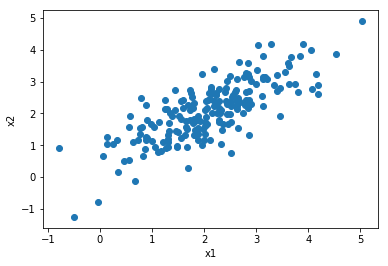

In [13]:
"""Set-up some data and plot it"""

np.random.seed(1)
m = 200
rho = 0.8
print('rho = ', rho, ', sqrt(1-rho^2) = ', np.sqrt(1.0 - rho*rho))
data = np.random.normal(size=(m, 2))
data[:,1] = rho*data[:,0] + np.sqrt(1.0-rho*rho)*data[:,1]
data = data + 2.0
plt.xlabel('x1')
plt.ylabel('x2')
ax = plt.scatter(data[:,0], data[:,1])

"""Do PCA and do some checks on the results"""
my_PCA = PCA(data)
my_PCA.calculation_checks()

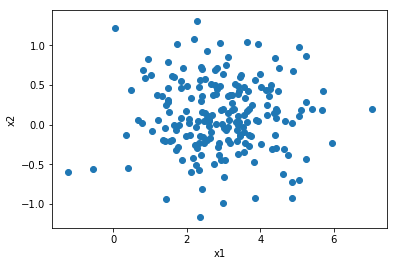

In [14]:
"""Plot the data in transformed space"""
new_data = my_PCA.transformed_X
plt.gcf().clear()
plt.close()
plt.xlabel('x1')
plt.ylabel('x2')
ax = plt.scatter(new_data[:,0], new_data[:,1])

## 6. K Nearest Neighbours

We have a set of labelled data ```{x, y}```. KNN is an instance based model which for any input ```x0``` predicts the output ```y0``` as the mean output of the k nearest input data points.

In [39]:
def euc_dists(x, p):
    return np.sqrt(np.sum((x-p)*(x-p), axis=1))

def cos_dists(x, p):
    return x*p / (euc_dist(x, np.zeros_like(p))*euc_dist(p, np.zeros_like(p)))
    
class KNN:
    def __init__(self, x, y):
        assert x.shape[0]== y.shape[0], 'KNN __init__: mismatched data sizes'
        self.x, self.y = x, y
        self.n_data = x.shape[0]
        self.n_y = y.shape[1]
    
    def predict(self, xs, k, dists):
        n_xs = xs.shape[0]
        predictions = np.ones((n_xs, self.n_y))
        for i in range(n_xs):
            k_indices = np.argsort(dists(self.x, xs[i,:]))[:k]
            knn = self.y[k_indices, :]
            if self.n_y == 1: predictions[i,:] = np.mean(knn)
            else:             predictions[i,:] = np.mean(knn, axis=1)
        print('nearest xs, nearest ys')
        print(np.concatenate((self.x[k_indices], knn), axis=1))
        return predictions

In [40]:
"""Set-up some data"""
np.random.seed(1)
m = 2000
rho = np.array([0.6, 0.2])
data = np.random.normal(size=(m, 3))
data[:,2] = rho[0]*data[:,0] + rho[1]*data[:,1] + np.sqrt(1.0-np.sum(rho*rho))*data[:,2]

"""Pick some xs to make predictions for"""
xs = np.random.normal(size=(1, 2))

"""Set-up the KNN object and predict the ys for our xs"""
my_knn = KNN(data[:,:2], data[:,2].reshape((m, 1)))
ys = my_knn.predict(xs, 5, euc_dists)

"""Print the xs and ys next to each other"""
print('xs, ys')
print(np.concatenate((xs, ys), axis=1))

nearest xs, nearest ys
[[-2.73914174  0.51031498 -1.73787473]
 [-2.51492462  0.81462501 -1.1321615 ]
 [-2.5822348   0.52339028 -0.85602195]
 [-2.69891898  0.28628856 -2.08910565]
 [-2.41020213  0.2617543  -2.02583533]]
xs, ys
[[-2.85106954  0.82312342 -1.56819983]]


## 7. Decision Tree

- We have a set of labelled data ```{x, y}```.
- Decision Trees are binary trees which partition data at each node based on a threshold on an input feature.
- At each node, the feature and the threshold at which to split the data on are chosen in training using a greedy optimization which seeks to minimise some cost.
- The tree should be grown to the fullest extent and then pruned to prevent overfitting.
- For both binary classification and regression the prediction is given by the mean ```y```. For binary classification the output is the probability, ```P(y = 1)```, for regression the predicted output is the expected value, ```E(y)```.

We implement a simplified version of the decision tree:
- Instead of optimising over both the threshold and feature on which we split the data, for each feature we fix threshold as the median value and optimise only over which feature to split on.
- To control the complexity of the representation, instead of pruning the tree after building it, we specify the maximum depth of the tree

In [28]:
def entropy(y):
    """y is binary"""
    p = np.mean(y)
    if p == 0 or p == 1:
        return 0
    return - p * np.log2(p) - (1.0 - p) * np.log2(1.0 - p)

def gini_idx(y):
    """y is binary"""
    p = np.mean(y)
    return 1 - p*p - (1.0 - p)*(1.0 - p)

def mean_sq_diffs(y):
    """y is binary"""
    y_bar = np.mean(y)
    return np.mean( (y - y_bar)*(y - y_bar) )

class Node:
    def __init__(self, x, y, f_cost, pct_min=10, pct_max=90, n_pct=9):
        self.x, self.y = x, y
        self.n_data, self.n_feat = x.shape
        self.f_cost, self.cost = f_cost, f_cost(y)
        self.pct_min, self.pct_max = pct_min, pct_max
        self.n_pct = n_pct
        self.thresholds = self._thresholds(pct_min, pct_max, n_pct)
        self.feature, self.threshold = self.best_feature_split()
        self.y_pred = np.mean(y)
        self.left = None
        self.right = None
    
    def set_child(self, side, x, y):
        if side == 'left':
            self.left  = Node(x, y, self.f_cost, self.pct_min, self.pct_max, self.n_pct)
        if side == 'right':
            self.right = Node(x, y, self.f_cost, self.pct_min, self.pct_max, self.n_pct)
    
    def _thresholds(self, pct_min, pct_max, n_pct):
        thresholds = np.zeros((n_pct, self.n_feat))
        for i, p in enumerate(np.linspace(pct_min, pct_max, n_pct)):
            thresholds[i,:] = np.percentile(self.x, p, axis=0)
        return thresholds
    
    def best_feature_split(self):
        min_cost = self.cost
        feature, threshold = -1, -1
        for i in range(self.n_feat):
            for t in range(self.n_pct):
                left_idxs = self.x[:,i] <= self.thresholds[t, i]
                left_y = self.y[left_idxs]
                right_y = self.y[np.logical_not(left_idxs)]
                p = left_y.shape[0] / self.n_data
                new_cost = p * self.f_cost(left_y) + (1.0 - p) * self.f_cost(right_y)
                if new_cost < min_cost:
                    min_cost = new_cost
                    feature = i
                    threshold = self.thresholds[t, i]
        #print('Best Split => n: {}, feat: {}, thld: {:4.3f}, cost: {}'.format(self.n_data, feature, threshold, min_cost))
        return feature, threshold

class DecisionTree:
    def __init__(self, root, max_depth = 4):
        self.root = root
        self.max_depth = max_depth
        self.build_tree(root, max_depth)
    
    def build_tree(self, node, depth):
        #print('depth: {}, cost: {}'.format(depth, node.cost))
        #print('\nBuild Tree => n: {}, depth:{}, feat: {}, thld: {:4.3f}'.format(node.n_data, depth, node.feature, node.threshold))
        if node.feature != -1 and depth > 0:
            idxs = node.x[:, node.feature] <= node.threshold
            node.set_child('left', node.x[idxs], node.y[idxs])
            idxs = np.logical_not(idxs)
            node.set_child('right', node.x[idxs], node.y[idxs])
            self.build_tree( node.left, depth-1 )
            self.build_tree( node.right, depth-1 )
    
    def predict(self, x):
        y_preds = np.zeros(x.shape[0])
        for i in range(x.shape[0]):
            node = self.root
            while not(node.left and node.right):
                if x[i,node.feature] <= node.threshold:
                    node = node.left
                else:
                    node = node.right
            y_preds[i] = node.y_pred
        return y_preds

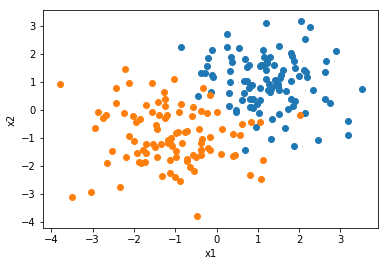

In [29]:
"""Set-up some data"""
np.random.seed(1)
x = 1
m = 200
data1 = np.concatenate((np.random.normal(size=(int(m/2), 2)) + [ x, x], np.ones((int(m/2), 1))), axis=1)
data2 = np.concatenate((np.random.normal(size=(int(m/2), 2)) + [-x, -x], np.zeros((int(m/2), 1))), axis=1)
data  = np.concatenate((data1, data2))
np.random.shuffle(data)
#data_df = pd.DataFrame(data=data, columns=['x1', 'x2', 'y'])
#display(data_df)
y = data[:,2]
#print(data[:,:2].shape)

"""Plot the different classes"""
plt.xlabel('x1')
plt.ylabel('x2')
ax = plt.scatter(data1[:,0], data1[:,1])
ax = plt.scatter(data2[:,0], data2[:,1])

Best Split => n: 200, feat: 0, thld: -0.377
Best Split => n: 80, feat: 1, thld: -0.011
Best Split => n: 120, feat: 1, thld: -0.400
Best Split => n: 64, feat: -1, thld: -1.000
Best Split => n: 16, feat: 0, thld: -0.866
Best Split => n: 13, feat: -1, thld: -1.000
Best Split => n: 3, feat: 1, thld: 0.197
Best Split => n: 1, feat: -1, thld: -1.000
Best Split => n: 2, feat: -1, thld: -1.000
Best Split => n: 24, feat: 0, thld: 1.209
Best Split => n: 96, feat: 1, thld: 0.799
Best Split => n: 19, feat: 0, thld: 0.605
Best Split => n: 5, feat: -1, thld: -1.000
Best Split => n: 11, feat: -1, thld: -1.000
Best Split => n: 8, feat: 0, thld: 0.979
Best Split => n: 5, feat: 1, thld: -0.616
Best Split => n: 3, feat: -1, thld: -1.000
Best Split => n: 3, feat: 1, thld: -2.132
Best Split => n: 2, feat: -1, thld: -1.000
Best Split => n: 1, feat: -1, thld: -1.000
Best Split => n: 2, feat: -1, thld: -1.000
Best Split => n: 39, feat: 0, thld: -0.020
Best Split => n: 57, feat: -1, thld: -1.000
Best Split => 

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


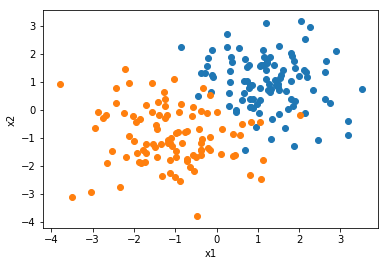

In [31]:
"""Set-up the tree"""
root = Node(data[:, :2], y, entropy)
max_depth = 8
Dtree = DecisionTree(root, max_depth)

"""Make predictions"""
y_pred = Dtree.predict(data[:, :2])
sum_sq_diffs = np.sum((y-y_pred)*(y-y_pred))
print('depth: {}, sum_sq_diffs: {:4.2f}'.format(max_depth, sum_sq_diffs))

threshold = 0.5
plt.xlabel('x1')
plt.ylabel('x2')
ax = plt.scatter(data[y_pred >  threshold,0], data[y_pred >  threshold,1])
ax = plt.scatter(data[y_pred <= threshold,0], data[y_pred <= threshold,1])

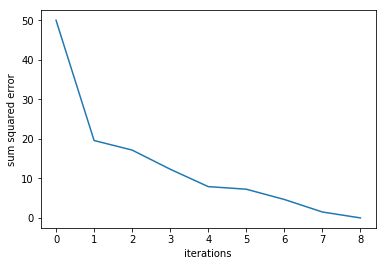

In [20]:
"""Set-up the tree"""
root = Node(data[:, :2], y, entropy)
sum_sq_diffs = []
for max_depth in range(9):
    Dtree = DecisionTree(root, max_depth)
    """Make predictions for a given depth"""
    y_pred = Dtree.predict(data[:, :2])
    sum_sq_diffs.append(np.sum((y-y_pred)*(y-y_pred)))

plt.gcf().clear()
plt.close()
plt.xlabel('iterations')
plt.ylabel('sum squared error')
ax = plt.plot(list(range(9)), sum_sq_diffs)

## 7. Support Vector Machine



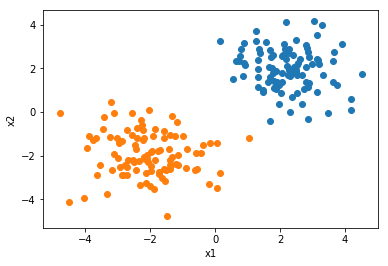

In [21]:
"""Set-up some data"""
np.random.seed(1)
x = 2
m = 200
data1 = np.concatenate((np.random.normal(size=(int(m/2), 2)) + [ x, x], np.ones((int(m/2), 1))), axis=1)
data2 = np.concatenate((np.random.normal(size=(int(m/2), 2)) + [-x, -x], np.zeros((int(m/2), 1))), axis=1)
data  = np.concatenate((data1, data2))
np.random.shuffle(data)
#data_df = pd.DataFrame(data=data, columns=['x1', 'x2', 'y'])
#display(data_df)
y = data[:,2]
#print(data[:,:2].shape)

"""Plot the different classes"""
plt.xlabel('x1')
plt.ylabel('x2')
ax = plt.scatter(data1[:,0], data1[:,1])
ax = plt.scatter(data2[:,0], data2[:,1])